In [1]:
import numpy as np
import matplotlib.pylab as plt
import torch, requests
from io import BytesIO
from PIL import Image
from torchvision import transforms as TF
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from utils.diffseg_pytorch import run_diffseg
from utils.simple_ptp_utils import set_attention_processors, SimpleAttentionStore

In [2]:
device = torch.device("cuda:0")
dtype = torch.float16

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=dtype)
# pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
image_transform = TF.Compose([
    TF.Resize((768, 768)),
    TF.ToTensor(),
    TF.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
def load_image(image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    image = image_transform(image)
    return image


@torch.inference_mode()
def encode_images(pipe, images):
    z = pipe.vae.encode(images).latent_dist.mode()
    z = z * pipe.vae.config.scaling_factor
    return z


@torch.inference_mode()
def decode_images(pipe, z):
    z = z / pipe.vae.config.scaling_factor
    image = pipe.vae.decode(z).sample
    image = image.clamp(-1, 1)
    return image


@torch.inference_mode()
def encode_prompt(pipe, prompts):
    text_inputs = pipe.tokenizer(
        prompts,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    input_ids = text_inputs.input_ids.to(pipe.device)
    prompt_embeds = pipe.text_encoder(input_ids, attention_mask=None)

    tokens = pipe.tokenizer.convert_ids_to_tokens(input_ids[0])
    return prompt_embeds[0], tokens


@torch.inference_mode()
def run_diffusion_forward(pipe, latents, t, prompt_embeds, seed=None):
    a_t = pipe.scheduler.alphas_cumprod[t]
    b_t = 1 - a_t

    if seed is not None:
        torch.manual_seed(seed)
    noise = torch.randn_like(latents)

    latents_t = latents * (a_t ** 0.5) + noise * (b_t ** 0.5)
    
    attention_store = SimpleAttentionStore()
    set_attention_processors(pipe, attention_store)
    pipe.unet(latents_t, t, prompt_embeds)

    return attention_store

In [7]:
def run_diffseg_exp(image_url, prompt="", attn_token_indices=None, add_semantic=False, batch_size=32):
    image = load_image(image_url)
    image = image[None].to(device, dtype)
    
    latents = encode_images(pipe, image)
    prompt_embeds, tokens = encode_prompt(pipe, [prompt])

    attention_store = run_diffusion_forward(pipe, latents, t=20, prompt_embeds=prompt_embeds, seed=47)
    self_attention_maps = attention_store.get_self_attention_maps()
    cross_attention_maps = attention_store.get_cross_attention_maps()

    segmentation_proposals = run_diffseg(
        self_attention_maps,
        cross_attention_maps,
        anchor_grid_size=(16, 16),
        target_size=(768, 768),
        tau=0.9,
        n_iters=100,
        batch_size=batch_size,
        add_semantic=add_semantic,
        attn_token_indices=attn_token_indices,
        device=pipe.device,
        dtype=pipe.dtype
    )

    if add_semantic:
        semantic = {i: [tokens[j] for j in attn_token_indices[i]] for i in range(len(attn_token_indices))}
        print(semantic)

    image_vis = image[0].permute(1, 2, 0).float().cpu().numpy()*0.5 + 0.5
    segmentation_proposals_vis = segmentation_proposals[0].float().cpu().numpy()


    plt.subplot(1, 2, 1)
    plt.imshow(image_vis)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_proposals_vis)
    plt.axis("off")

    plt.show()


## Without semantic labels

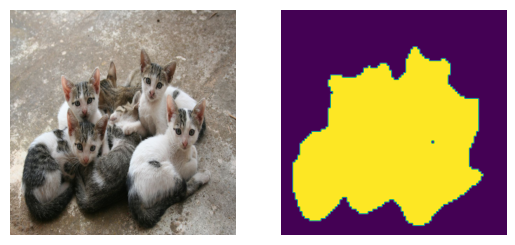

In [ ]:
image_url = "https://c2.staticflickr.com/3/2065/2096277438_c35fc13ba2_o.jpg"
run_diffseg_exp(image_url)

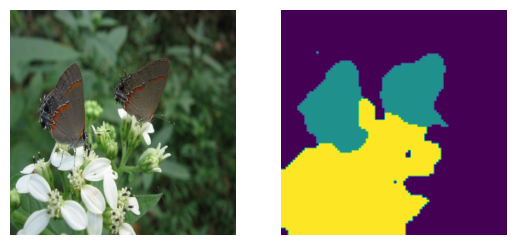

In [ ]:
image_url = "https://farm3.staticflickr.com/1325/1307182765_090926ecc4_o.jpg"
run_diffseg_exp(image_url)

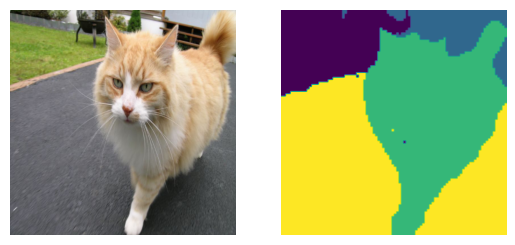

In [ ]:
image_url = "https://farm1.staticflickr.com/1052/1307177088_458aec9691_o.jpg"
run_diffseg_exp(image_url)

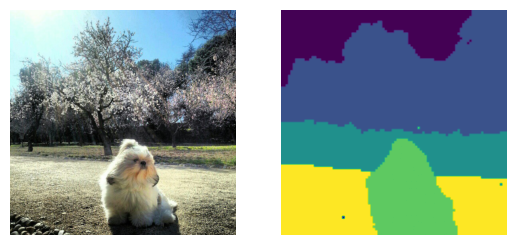

In [ ]:
image_url = "https://farm4.staticflickr.com/8093/8500931688_d093e69b45_o.jpg"
run_diffseg_exp(image_url)

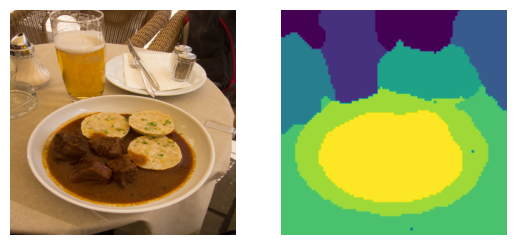

In [ ]:
image_url = "https://farm3.staticflickr.com/7375/14124836862_c7282ebf1a_o.jpg"
run_diffseg_exp(image_url)

## With semantic labels

{0: ['cats</w>'], 1: ['road</w>']}


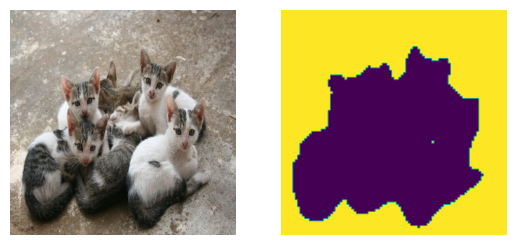

In [ ]:
image_url = "https://c2.staticflickr.com/3/2065/2096277438_c35fc13ba2_o.jpg"
run_diffseg_exp(image_url, add_semantic=True, prompt="cats on a road", attn_token_indices=[[1], [4]])

{0: ['two</w>', 'butterflies</w>'], 1: ['flowers</w>']}


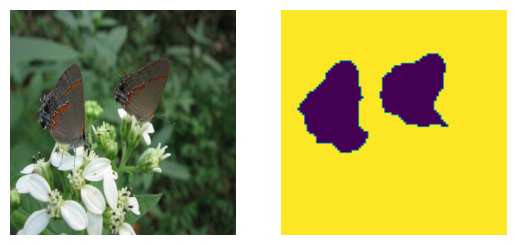

In [9]:
image_url = "https://farm3.staticflickr.com/1325/1307182765_090926ecc4_o.jpg"
run_diffseg_exp(image_url, add_semantic=True, prompt="two butterflies sitting on flowers", attn_token_indices=[[1, 2], [5]])

{0: ['cat</w>'], 1: ['road</w>']}


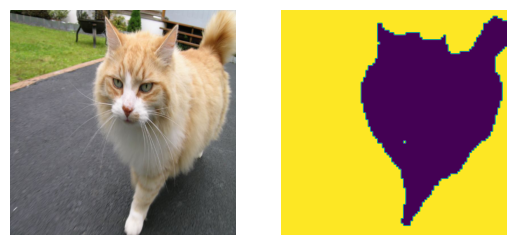

In [10]:
image_url = "https://farm1.staticflickr.com/1052/1307177088_458aec9691_o.jpg"
run_diffseg_exp(image_url, add_semantic=True, prompt="a cat walking on a road", attn_token_indices=[[2], [6]])

{0: ['dog</w>'], 1: ['road</w>'], 2: ['woods</w>'], 3: ['blue</w>', 'sky</w>']}


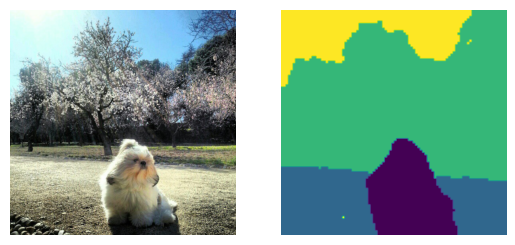

In [17]:
image_url = "https://farm4.staticflickr.com/8093/8500931688_d093e69b45_o.jpg"
run_diffseg_exp(image_url, add_semantic=True, prompt="a dog standing on a road with woods and blue sky background.", attn_token_indices=[[2], [6], [8], [10, 11]])